# Unsupervised Learning Trading Strategy

- Download/Load S&P 500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to S&P500 returns.


In [26]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-04-11'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()
df = df.groupby(level='ticker').filter(lambda x: len(x) >= 20) # we need tickers with atleast 20 datapoints
df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-04-13 A        38.182766   40.689999   41.000000   39.500000   39.520000   
           AAL      38.272621   39.939999   40.009998   38.889999   39.299999   
           AAPL     25.605806   28.010000   28.084999   27.700001   27.700001   
           ABBV     42.245777   59.060001   60.000000   58.700001   59.869999   
           ABT      37.601128   43.349998   43.419998   42.680000   42.869999   
...                       ...         ...         ...         ...         ...   
2024-04-10 XYL     128.190002  128.190002  128.779999  126.019997  126.690002   
           YUM     137.949997  137.949997  138.149994  134.820007  135.029999   
           ZBH     127.720001  127.720001  127.940002  126.389999  127.809998   
           ZBRA    299.910004  299.910004  304.809998  296.420013  297.380005   
           ZTS     163.199997  163.199997  164.869995  162.639999  164.259995   

Price                   volume  
date       ticker               
2016-04-13 A         2494600.0  
           AAL      12493500.0  
           AAPL    133029200.0  
           ABBV      7023000.0  
           ABT       4140700.0  
...                        ...  
2024-04-10 XYL       1036900.0  
           YUM       1901000.0  
           ZBH        823300.0  
           ZBRA       287600.0  
           ZTS       2666000.0  

[991864 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume


# Technical Indicators for Stock Analysis

In financial market analysis, technical indicators are crucial for understanding market behavior and potential price movements. Below are detailed descriptions and formulas for several key technical indicators:

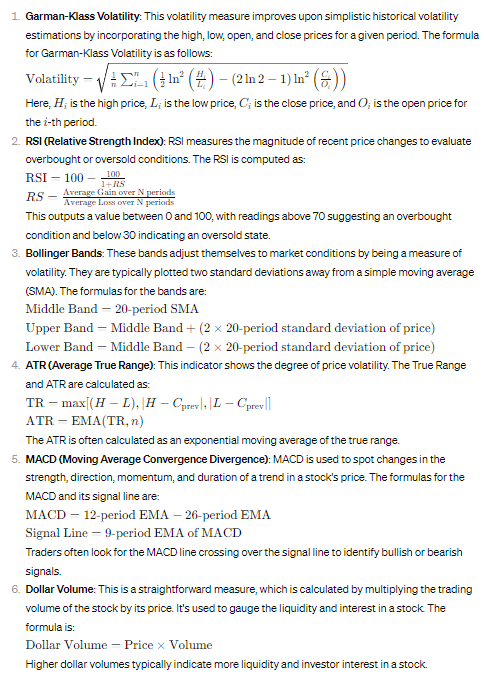

In [27]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df




Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-04-13 A        38.182766   40.689999   41.000000   39.500000   39.520000   
           AAL      38.272621   39.939999   40.009998   38.889999   39.299999   
           AAPL     25.605806   28.010000   28.084999   27.700001   27.700001   
           ABBV     42.245777   59.060001   60.000000   58.700001   59.869999   
           ABT      37.601128   43.349998   43.419998   42.680000   42.869999   
...                       ...         ...         ...         ...         ...   
2024-04-10 XYL     128.190002  128.190002  128.779999  126.019997  126.690002   
           YUM     137.949997  137.949997  138.149994  134.820007  135.029999   
           ZBH     127.720001  127.720001  127.940002  126.389999  127.809998   
           ZBRA    299.910004  299.910004  304.809998  296.420013  297.380005   
           ZTS     163.199997  163.199997  164.869995  162.639999  164.259995   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-04-13 A         2494600.0          0.000237        NaN       NaN   
           AAL      12493500.0          0.000132        NaN       NaN   
           AAPL    133029200.0         -0.002292        NaN       NaN   
           ABBV      7023000.0         -0.046722        NaN       NaN   
           ABT       4140700.0         -0.006495        NaN       NaN   
...                        ...               ...        ...       ...   
2024-04-10 XYL       1036900.0          0.000181  57.029736  4.851484   
           YUM       1901000.0          0.000121  54.133706  4.905253   
           ZBH        823300.0          0.000074  52.048372  4.827316   
           ZBRA       287600.0          0.000362  58.417494  5.638746   
           ZTS       2666000.0          0.000077  34.561066  5.091065   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-04-13 A            NaN       NaN       NaN       NaN      95.250728  
           AAL          NaN       NaN       NaN       NaN     478.158992  
           AAPL         NaN       NaN       NaN       NaN    3406.319934  
           ABBV         NaN       NaN       NaN       NaN     296.692093  
           ABT          NaN       NaN       NaN       NaN     155.694989  
...                     ...       ...       ...       ...            ...  
2024-04-10 XYL     4.862657  4.873830  0.019402  0.340849     132.920214  
           YUM     4.928410  4.951568  0.362337 -0.006190     262.242944  
           ZBH     4.858077  4.888838 -0.531731  0.251293     105.151877  
           ZBRA    5.683678  5.728610  0.095956  0.627823      86.254117  
           ZTS     5.132096  5.173127  0.779521 -2.333401     435.091192  

[991864 rows x 14 columns]

### Step 3: Monthly Aggregation and Liquidity Filtering

- **Aggregate to Monthly Level**: We convert the business-daily data into month-end frequency to facilitate easier analysis and reduce computational load.
- **Filter Top 150 Most Liquid Stocks**: For each month, we filter for the top 150 stocks with the highest liquidity. This is done to focus on the most traded stocks, assuming that liquidity is proxied by the trading volume.


In [28]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-05-31 A          104.556236   43.062363         -0.001415  77.715293   
           AAL        304.649004   30.666256         -0.000261  31.471690   
           AAPL      3737.581213   22.961117         -0.002413  50.629789   
           ABBV       431.810205   45.014004         -0.042372  60.599507   
           ABT        398.829157   34.374462         -0.006916  47.644607   
...                          ...         ...               ...        ...   
2024-04-30 ABNB       434.207067  160.279999          0.000100  51.402676   
           CEG        519.376780  191.080002          0.001181  67.480285   
           GEHC       246.826623   85.389999          0.000144  44.648898   
           KVUE       244.546964   20.240000          0.000087  49.815653   
           VLTO       136.074477   88.199997          0.000092  55.223437   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-05-31 A       3.652142  3.731073  3.810005 -1.319721  0.468276  
           AAL     3.423399  3.470762  3.518124 -0.101148 -2.013979  
           AAPL    3.067554  3.128054  3.188554 -1.152907 -0.364369  
           ABBV    3.767178  3.809104  3.851030 -1.108354 -0.157208  
           ABT     3.498909  3.529178  3.559447 -1.221812 -0.952385  
...                     ...       ...       ...       ...       ...  
2024-04-30 ABNB    5.065456  5.102625  5.139794 -0.905670  0.129526  
           CEG     5.101737  5.203140  5.304542  5.230017  2.539006  
           GEHC    4.467684  4.500310  4.532936 -0.084560 -0.598076  
           KVUE    3.031079  3.069931  3.108783 -1.222634  0.871413  
           VLTO    4.465462  4.489780  4.514098 -1.184006 -0.408740  

[47324 rows x 9 columns]

In [29]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-04-30 AAL      41.276726         -0.001000  45.213616  3.691857   
           AAPL     33.524036         -0.001970  61.191500  3.520674   
           ABBV     48.986908         -0.034448  63.760455  3.870198   
           ABT      38.811474         -0.005357  48.977544  3.668610   
           ACN     109.199356         -0.003493  58.138703  4.640366   
...                       ...               ...        ...       ...   
2024-04-30 WMT      60.619999          0.000153  60.466266  4.096675   
           XOM     122.199997          0.000077  78.846653  4.696046   
           MRNA    107.139999          0.000814  54.442709  4.616701   
           UBER     74.349998          0.000283  46.841382  4.316207   
           ABNB    160.279999          0.000100  51.402676  5.065456   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-04-30 AAL     3.766755  3.841652  0.804182  0.657352  
           AAPL    3.536714  3.552755 -1.239436 -0.156193  
           ABBV    3.889972  3.909746 -1.442489 -0.119795  
           ABT     3.683933  3.699257 -1.351731 -0.295123  
           ACN     4.670434  4.700503 -1.150573 -0.185646  
...                     ...       ...       ...       ...  
2024-04-30 WMT     4.117496  4.138317  0.307228  0.219398  
           XOM     4.760739  4.825432 -0.022461  2.935176  
           MRNA    4.667877  4.719053 -0.383069  0.134899  
           UBER    4.358458  4.400709  1.357426 -0.360008  
           ABNB    5.102625  5.139794 -0.905670  0.129526  

[12665 rows x 8 columns]

### Step 4: Calculating Monthly Returns for Various Time Horizons

- **Compute Historical Returns**: To account for time series dynamics, such as momentum patterns, we calculate historical returns over various monthly periods. This is done using the `.pct_change(lag)` method, where `lag` specifies the number of months over which the returns are calculated.


In [30]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-04-30 AAL      41.922886         -0.000233  34.064583  3.733074   
           AAPL     39.177345          0.000096  44.093198  3.663645   
           ABBV     74.159798         -0.031915  47.693787  4.229163   
           ABT      52.741085         -0.005614  45.310078  3.974422   
           ACN     138.647720         -0.003740  47.986210  4.904240   
...                       ...               ...        ...       ...   
2024-04-30 WMT      60.619999          0.000153  60.466266  4.096675   
           XOM     122.199997          0.000077  78.846653  4.696046   
           MRNA    107.139999          0.000814  54.442709  4.616701   
           UBER     74.349998          0.000283  46.841382  4.316207   
           ABNB    160.279999          0.000100  51.402676  5.065456   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-04-30 AAL     3.847312  3.961549  2.131496 -2.482282  -0.173787   
           AAPL    3.720439  3.777232 -0.825614 -0.515945  -0.015020   
           ABBV    4.280136  4.331109  0.975682 -0.924139   0.030640   
           ABT     3.996780  4.019137 -0.571772 -0.416441  -0.025204   
           ACN     4.936702  4.969163 -0.525793 -0.313044  -0.006292   
...                     ...       ...       ...       ...        ...   
2024-04-30 WMT     4.117496  4.138317  0.307228  0.219398   0.007479   
           XOM     4.760739  4.825432 -0.022461  2.935176   0.051273   
           MRNA    4.667877  4.719053 -0.383069  0.134899   0.005443   
           UBER    4.358458  4.400709  1.357426 -0.360008  -0.034290   
           ABNB    5.102625  5.139794 -0.905670  0.129526  -0.028371   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-04-30 AAL     -0.110429  -0.074851  -0.013677  -0.017083    0.001295  
           AAPL    -0.036775  -0.002988  -0.002490   0.013081    0.013071  
           ABBV    -0.082294  -0.045625   0.014256   0.039338    0.035160  
           ABT     -0.016043  -0.020529   0.013257   0.020388    0.025886  
           ACN     -0.026676  -0.017233   0.011571   0.020044    0.020096  
...                      ...        ...        ...        ...         ...  
2024-04-30 WMT      0.018733   0.033612   0.019196   0.015631    0.016857  
           XOM      0.081274   0.062554   0.027366   0.017610    0.005620  
           MRNA     0.077745   0.019698   0.058996  -0.010353   -0.017789  
           UBER    -0.032932   0.044373   0.094374   0.046332    0.075478  
           ABNB     0.008883   0.036012   0.051934   0.005771    0.024648  

[10502 rows x 14 columns]

### Step 5: Downloading Fama-French Factors and Calculating Rolling Factor Betas

- **Incorporate Fama-French Factors**: To account for common risk factors in asset pricing, we integrate the five Fama-French factors — market risk, size, value, operating profitability, and investment — into our analysis.
- **Empirical Evidence**: These factors have been empirically shown to explain asset returns and are commonly utilized for assessing the risk/return profile of portfolios.
- **Historical Factor Returns**: Historical returns for these factors can be accessed using `pandas-datareader`.
- **Estimate Historical Exposures**: We use `RollingOLS`, a rolling linear regression method, to estimate historical exposures to these factors, providing us with insight into past factor exposures as financial features for our models.


In [32]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-04-30 AAL     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.173787
           AAPL    0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
           ABBV    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030640
           ABT     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.025204
           ACN     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.006292
...                   ...     ...     ...     ...     ...        ...
2024-02-29 VRTX    0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.029166
           VZ      0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.055018
           WFC     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.115593
           WMT     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.064024
           XOM     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.026081

[10216 rows x 6 columns]

In [33]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-04-30 AAL     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.173787
           AAPL    0.0028  0.0093  0.0054 -0.0242  0.0130  -0.015020
           ABBV    0.0028  0.0093  0.0054 -0.0242  0.0130   0.030640
           ABT     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.025204
           ACN     0.0028  0.0093  0.0054 -0.0242  0.0130  -0.006292
...                   ...     ...     ...     ...     ...        ...
2024-02-29 VRTX    0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.029166
           VZ      0.0506 -0.0078 -0.0348 -0.0198 -0.0213  -0.055018
           WFC     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.115593
           WMT     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.064024
           XOM     0.0506 -0.0078 -0.0348 -0.0198 -0.0213   0.026081

[10180 rows x 6 columns]

In [34]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-04-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-02-29 VRTX    0.326829  0.592502 -0.880360  0.213540  1.148968
           VZ      0.465110 -1.123148  0.785973  0.143684 -0.493699
           WFC     1.130586  0.277844  1.569917 -0.359532 -1.258982
           WMT     0.551393  0.245391 -0.959621  0.587578  0.954837
           XOM     0.812999 -0.009065  0.464574  0.827792  0.579605

[10180 rows x 5 columns]

In [35]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10335 entries, (Timestamp('2018-04-30 00:00:00'), 'AAL') to (Timestamp('2024-04-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10335 non-null  float64
 1   rsi               10335 non-null  float64
 2   bb_low            10335 non-null  float64
 3   bb_mid            10335 non-null  float64
 4   bb_high           10335 non-null  float64
 5   atr               10335 non-null  float64
 6   macd              10335 non-null  float64
 7   return_1m         10335 non-null  float64
 8   return_2m         10335 non-null  float64
 9   return_3m         10335 non-null  float64
 10  return_6m         10335 non-null  float64
 11  return_9m         10335 non-null  float64
 12  return_12m        10335 non-null  float64
 13  Mkt-RF            10335 non-null  float64
 14  SMB               10335 non-null  float64
 15  HML       

### Step 6: Fitting K-Means Clustering to Group Similar Assets

- **K-Means Clustering**: Each month, we apply the K-Means clustering algorithm to our dataset to identify groups of assets with similar features.
- **Initialization**: Initially, we employ the 'k-means++' method for selecting initial cluster centers in order to speed up convergence.
- **Predefined Centroids**: Based on prior research, we may define predefined centroids for each cluster to further refine our clustering process.
- **Visualization**: For the purposes of this tutorial, the clustering will be visualized, demonstrating the grouping of assets for the selected time period.


In [41]:
from sklearn.cluster import KMeans


def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-04-30 AAL            -0.000233  34.064583  3.733074  3.847312  3.961549   
           AAPL            0.000096  44.093198  3.663645  3.720439  3.777232   
           ABBV           -0.031915  47.693787  4.229163  4.280136  4.331109   
           ABT            -0.005614  45.310078  3.974422  3.996780  4.019137   
           ACN            -0.003740  47.986210  4.904240  4.936702  4.969163   
...                             ...        ...       ...       ...       ...   
2024-04-30 WFC             0.000117  57.658626  4.053134  4.066625  4.080116   
           WMT             0.000153  60.466266  4.096675  4.117496  4.138317   
           XOM             0.000077  78.846653  4.696046  4.760739  4.825432   
           MRNA            0.000814  54.442709  4.616701  4.667877  4.719053   
           UBER            0.000283  46.841382  4.316207  4.358458  4.400709   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-04-30 AAL     2.131496 -2.482282  -0.173787  -0.110429  -0.074851   
           AAPL   -0.825614 -0.515945  -0.015020  -0.036775  -0.002988   
           ABBV    0.975682 -0.924139   0.030640  -0.082294  -0.045625   
           ABT    -0.571772 -0.416441  -0.025204  -0.016043  -0.020529   
           ACN    -0.525793 -0.313044  -0.006292  -0.026676  -0.017233   
...                     ...       ...        ...        ...        ...   
2024-04-30 WFC    -0.293124  0.704885  -0.017598   0.012070   0.045463   
           WMT     0.307228  0.219398   0.007479   0.018733   0.033612   
           XOM    -0.022461  2.935176   0.051273   0.081274   0.062554   
           MRNA   -0.383069  0.134899   0.005443   0.077745   0.019698   
           UBER    1.357426 -0.360008  -0.034290  -0.032932   0.044373   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-04-30 AAL     -0.013677  -0.017083    0.001295  1.235768  1.410401   
           AAPL    -0.002490   0.013081    0.013071  1.323504 -0.361610   
           ABBV     0.014256   0.039338    0.035160  0.456356  0.554743   
           ABT      0.013257   0.020388    0.025886  0.807180 -0.145280   
           ACN      0.011571   0.020044    0.020096  1.221935 -0.177725   
...                      ...        ...         ...       ...       ...   
2024-04-30 WFC      0.064452   0.026290    0.033107  1.066169 -0.078862   
           WMT      0.019196   0.015631    0.016857  0.602102 -0.413937   
           XOM      0.027366   0.017610    0.005620  1.099171  0.211197   
           MRNA     0.058996  -0.010353   -0.017789  1.350157  0.625990   
           UBER     0.094374   0.046332    0.075478  1.116615  0.996607   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-04-30 AAL     0.484432  0.136416  0.796569        3  
           AAPL   -0.620725  0.463087  0.619576        2  
           ABBV   -0.170314  0.517062  0.383725        2  
           ABT    -0.479253  0.278064  0.966559        2  
           ACN    -0.279864  0.316912  0.140893        2  
...                     ...       ...       ...      ...  
2024-04-30 WFC     1.535923 -0.742868 -0.771128        0  
           WMT    -0.351969  0.274735  0.690452        0  
           XOM     0.776843 -0.472602  0.525219        1  
           MRNA   -1.245190  0.907541  1.026476        0  
           UBER   -0.277602 -1.443203 -0.437273        2  

[10335 rows x 19 columns]

In [42]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

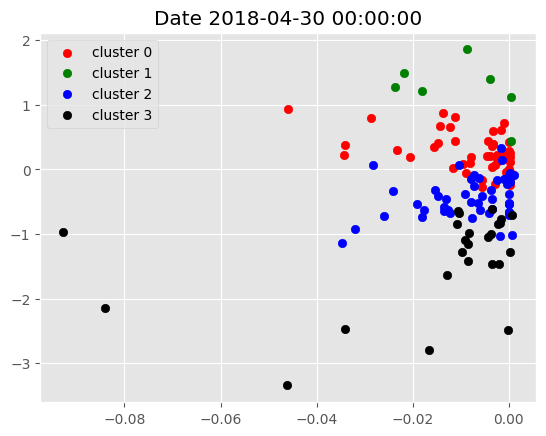

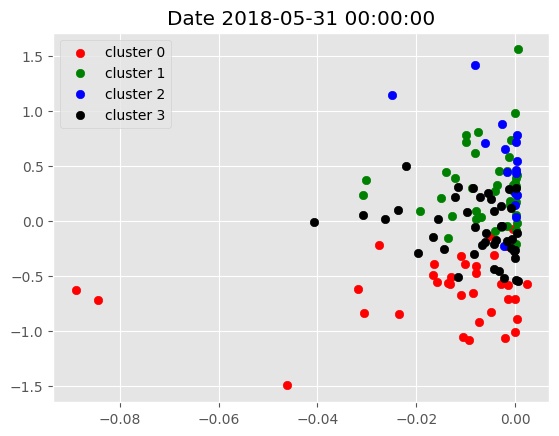

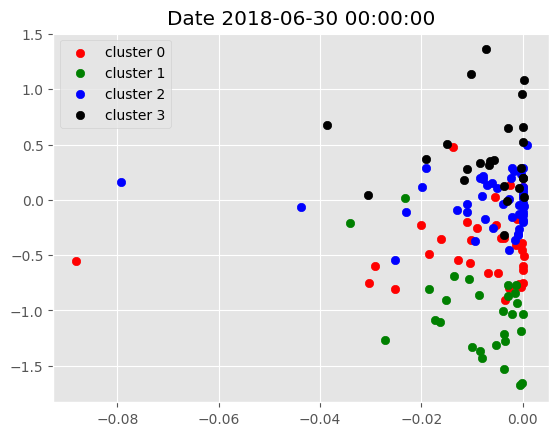

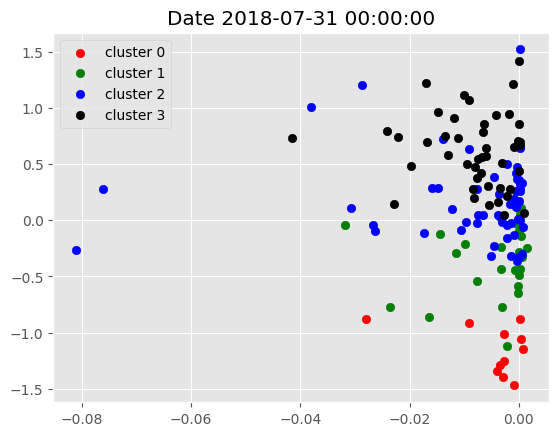

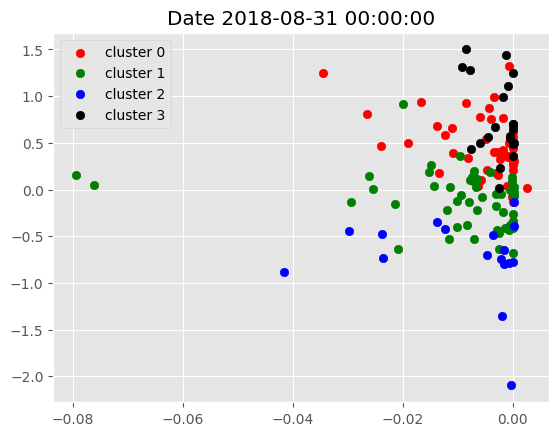

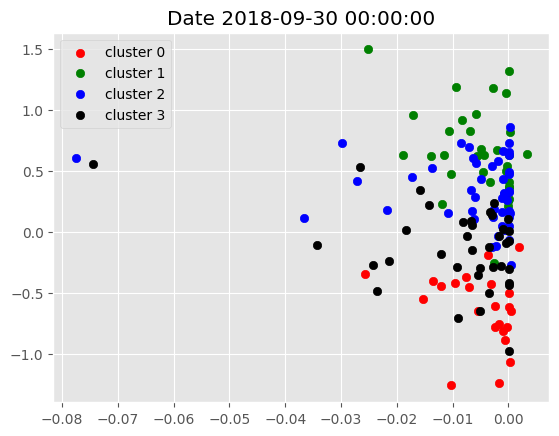

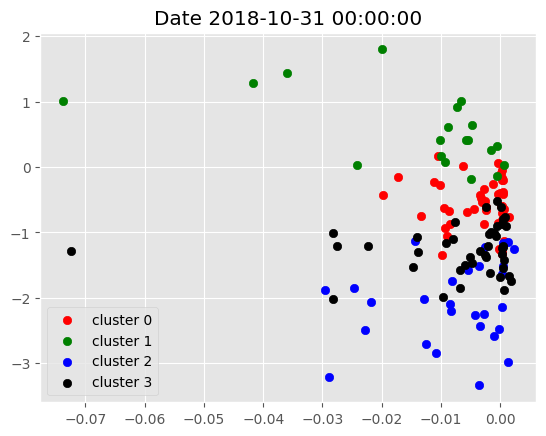

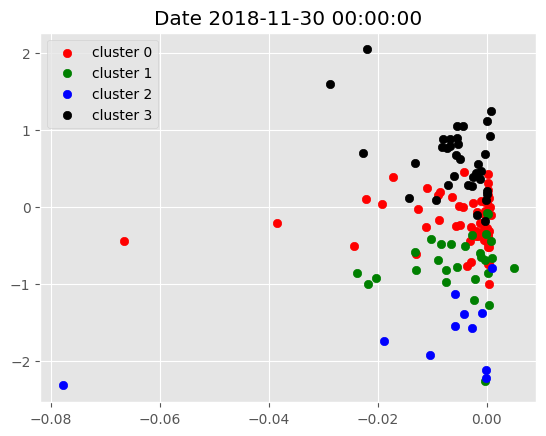

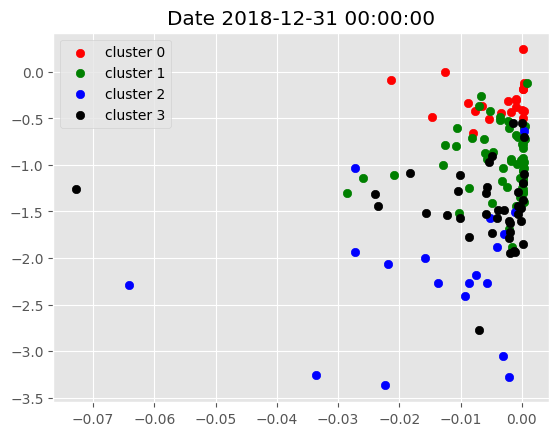

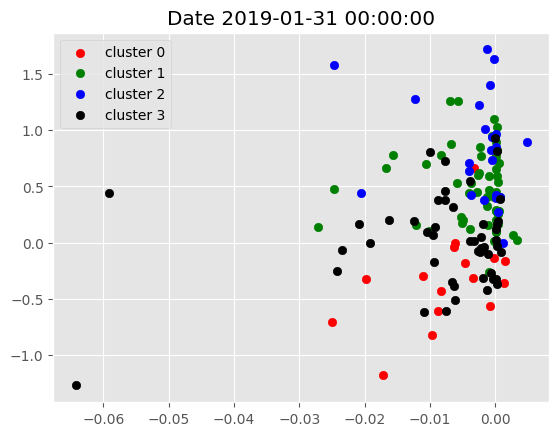

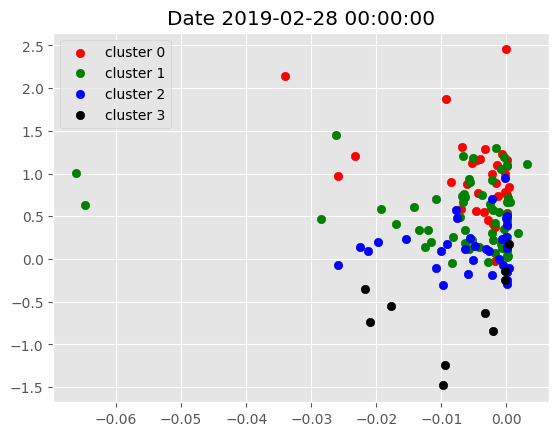

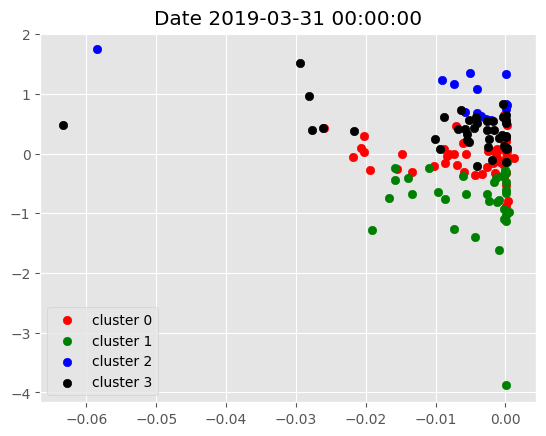

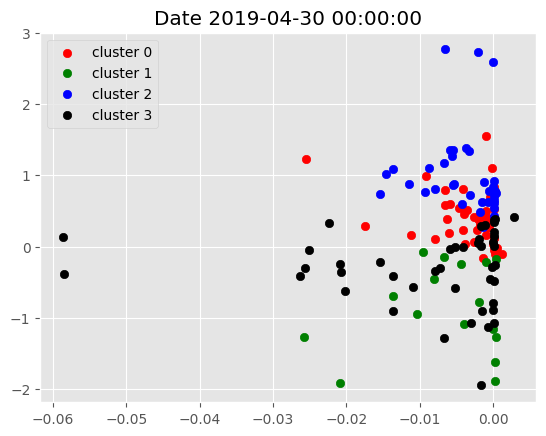

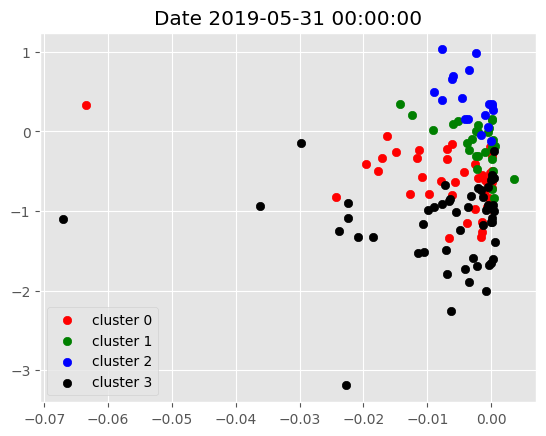

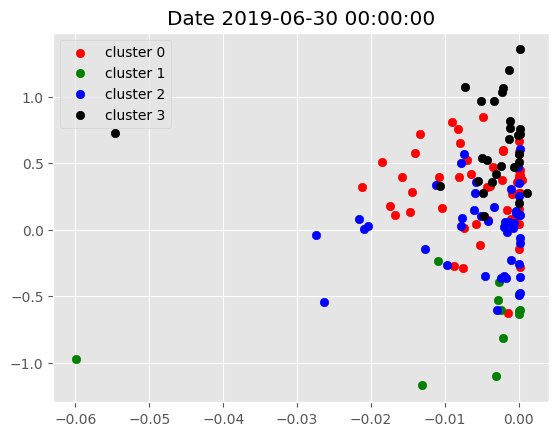

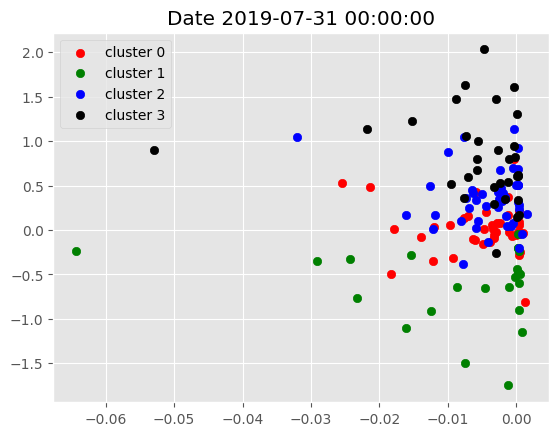

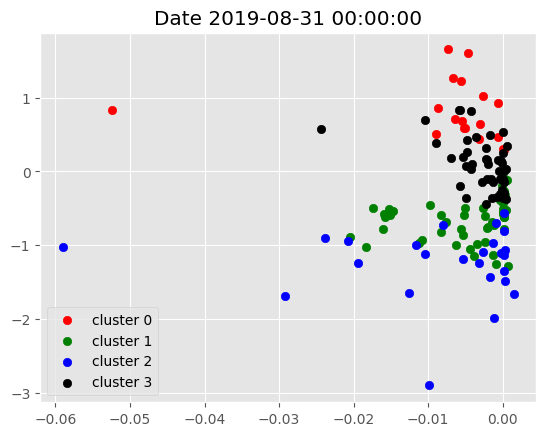

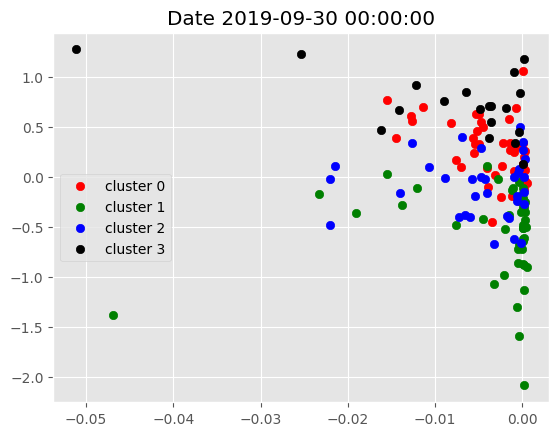

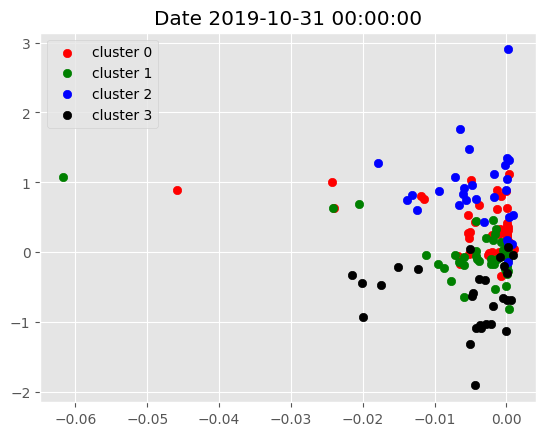

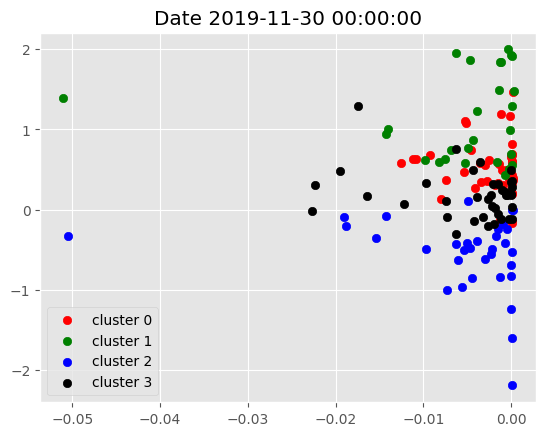

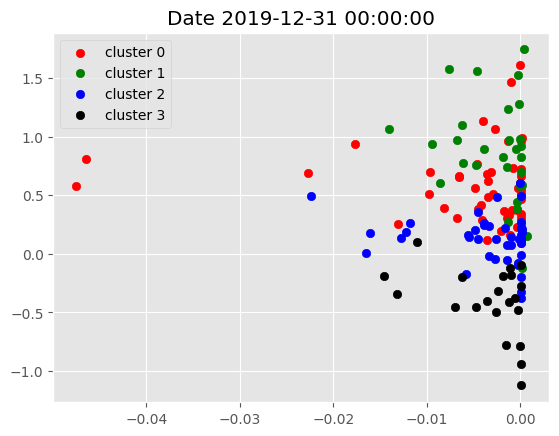

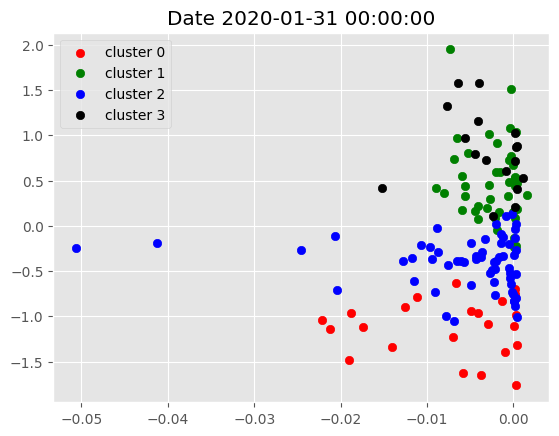

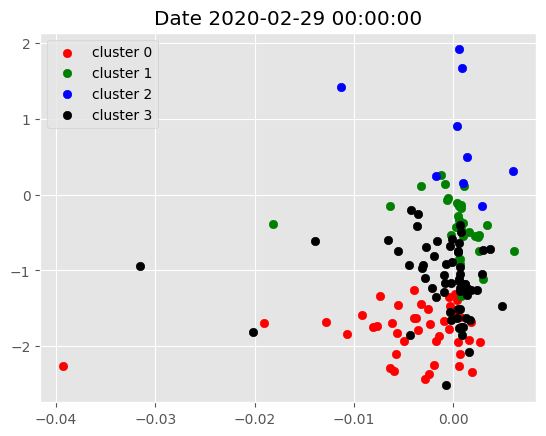

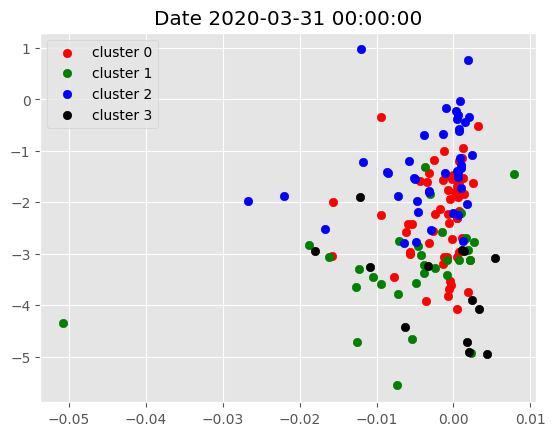

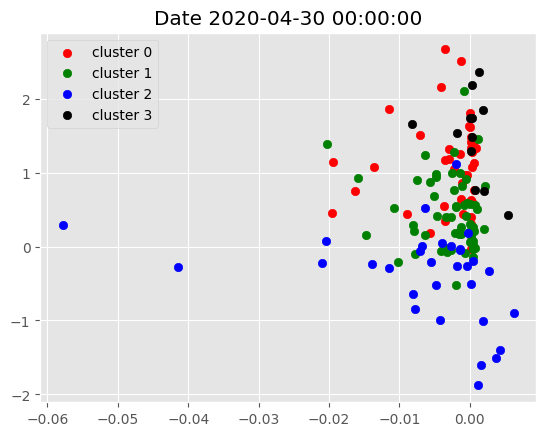

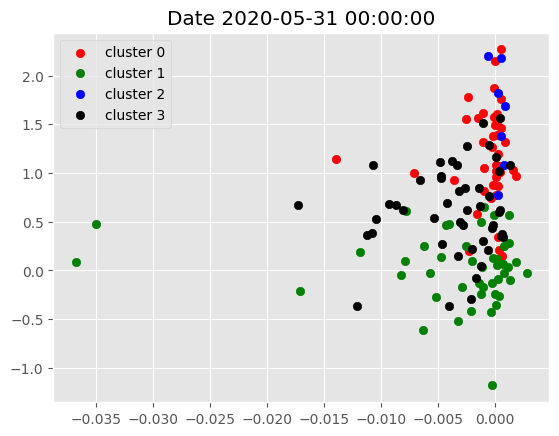

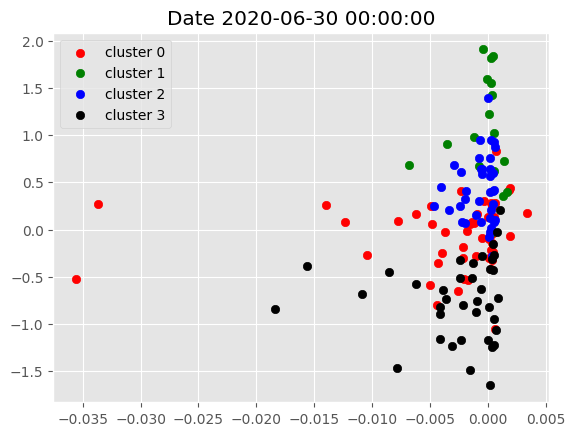

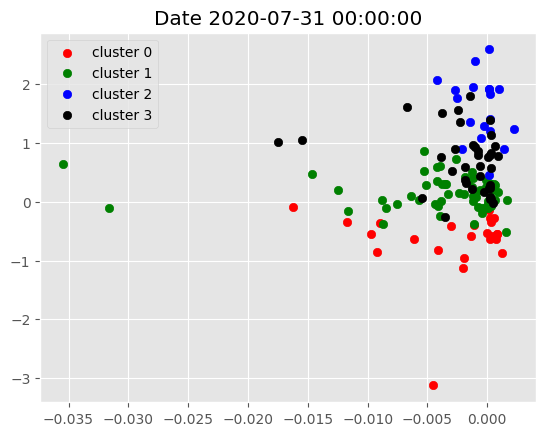

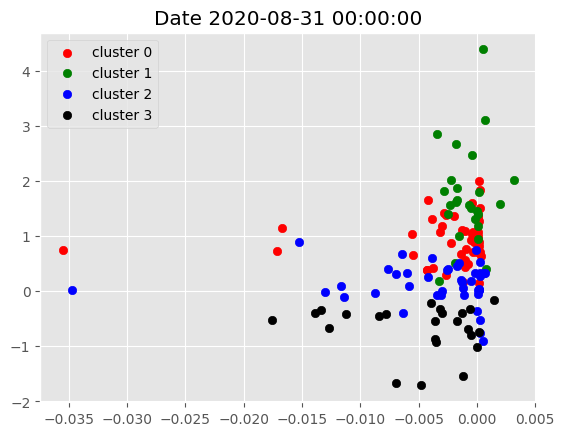

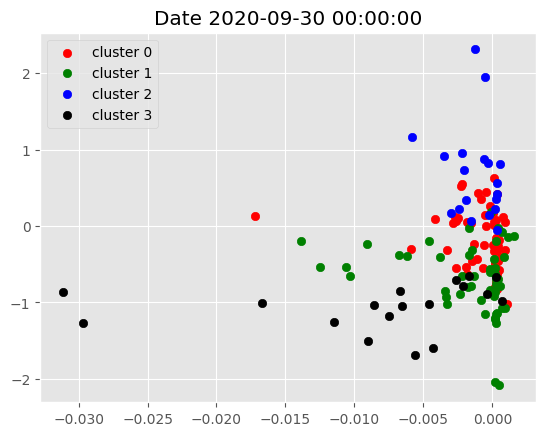

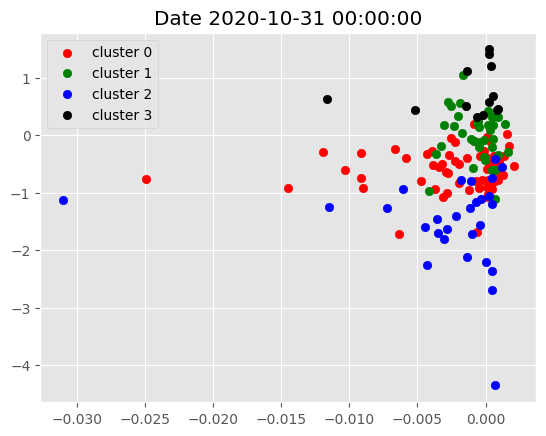

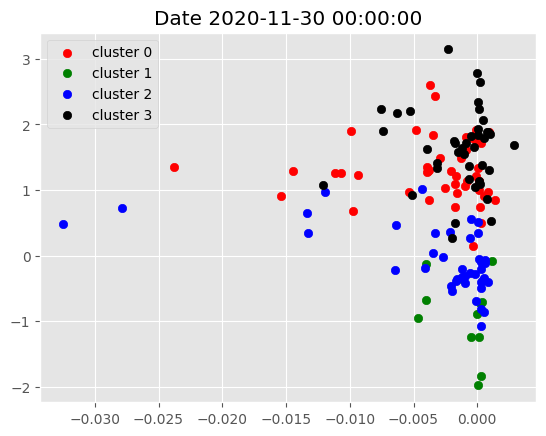

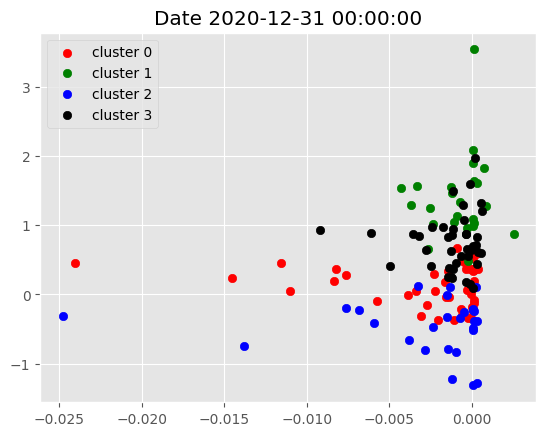

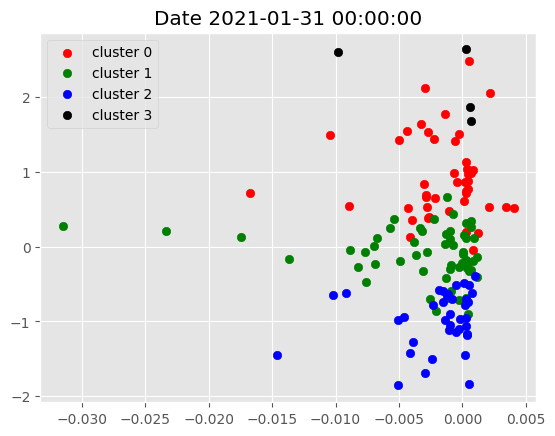

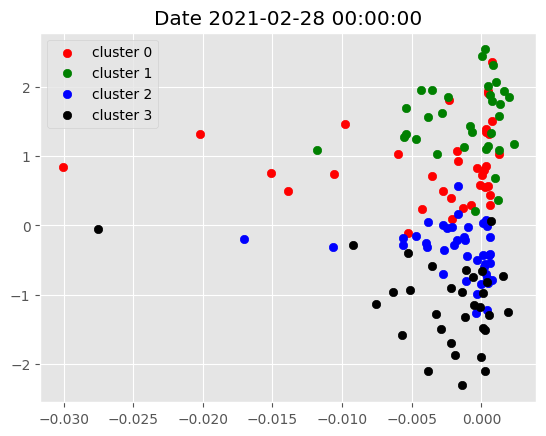

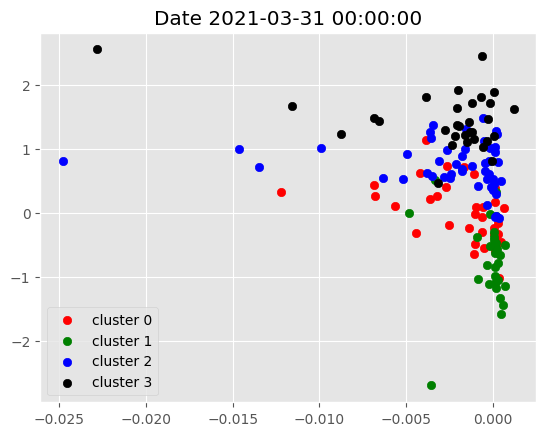

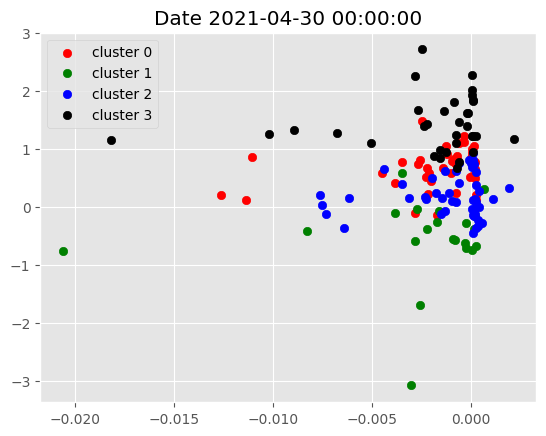

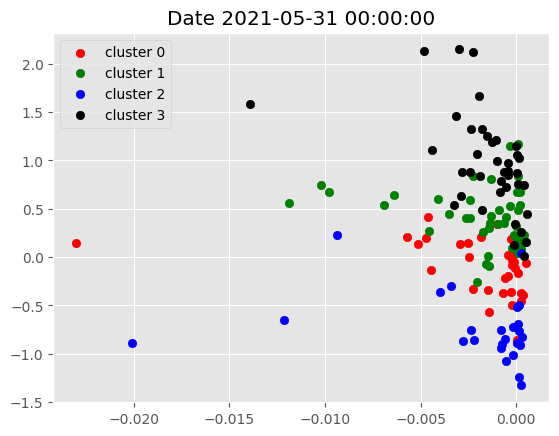

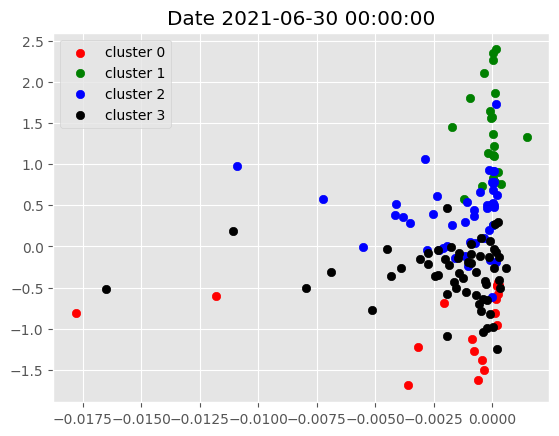

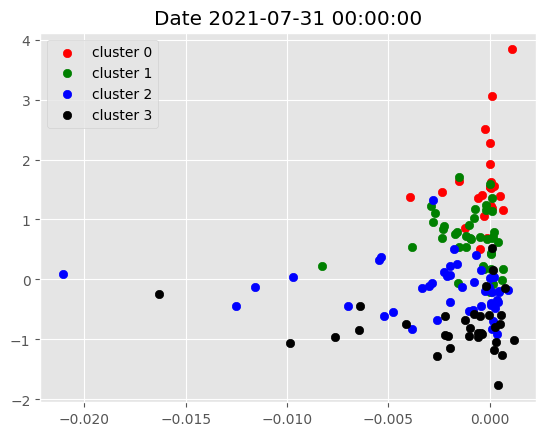

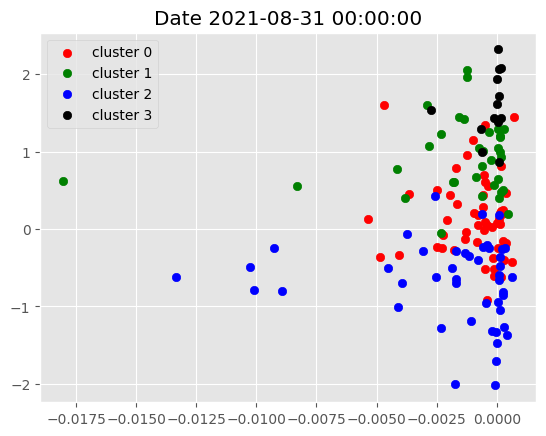

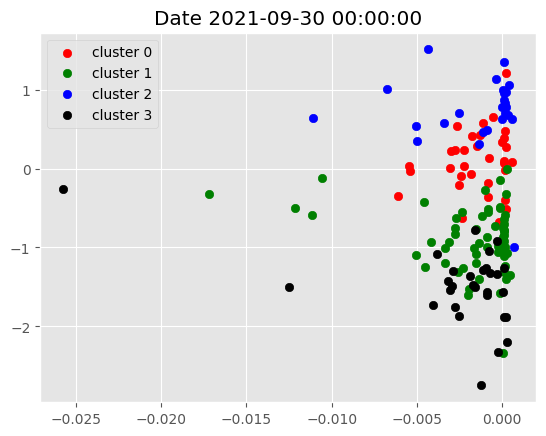

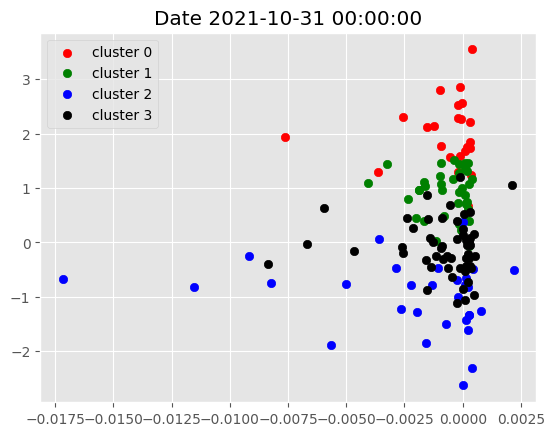

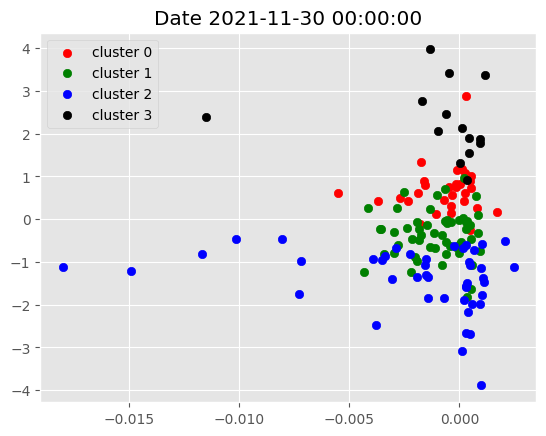

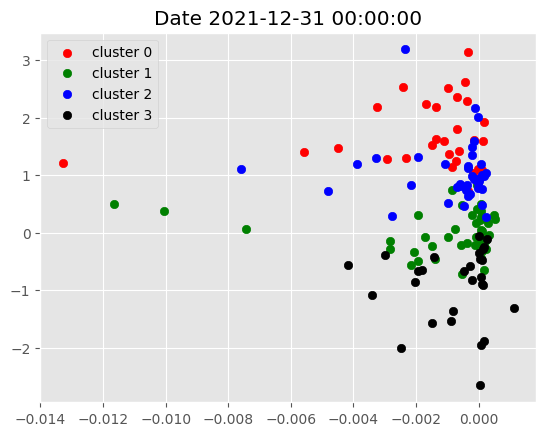

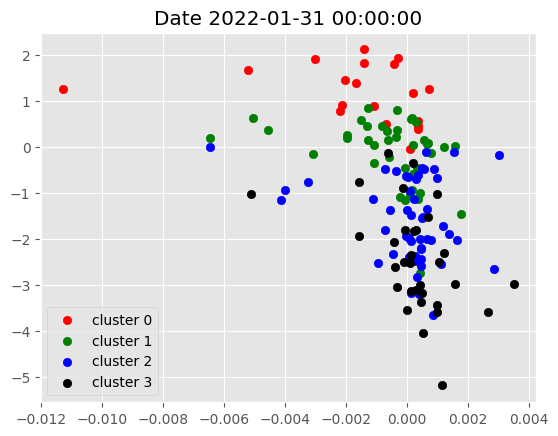

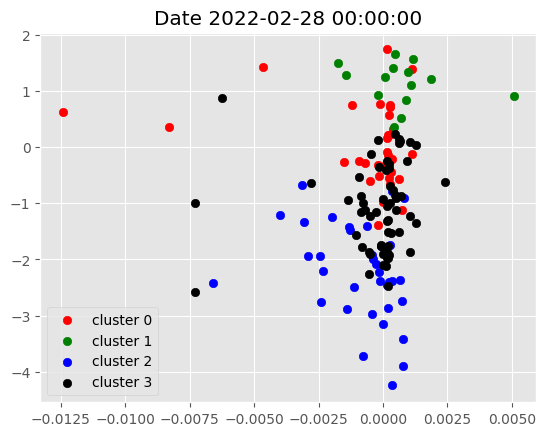

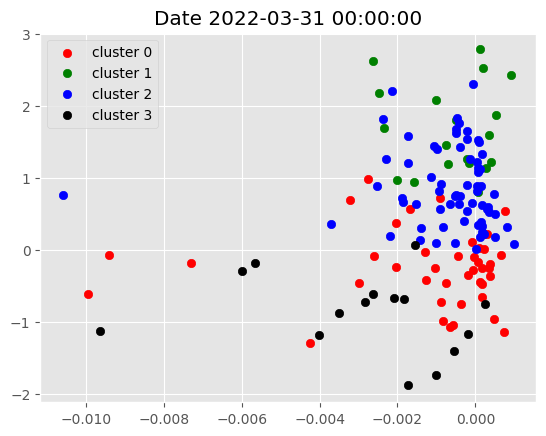

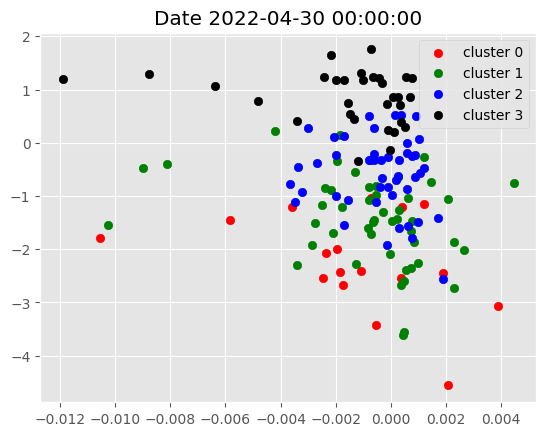

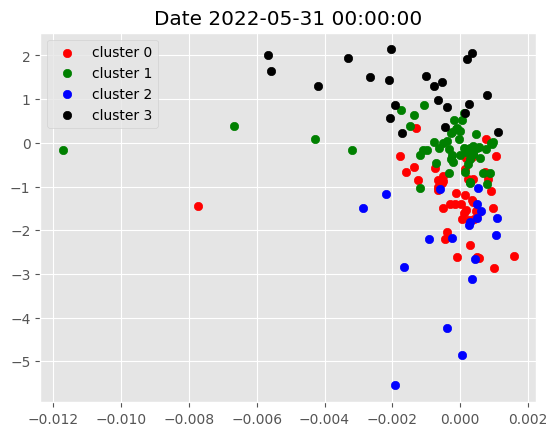

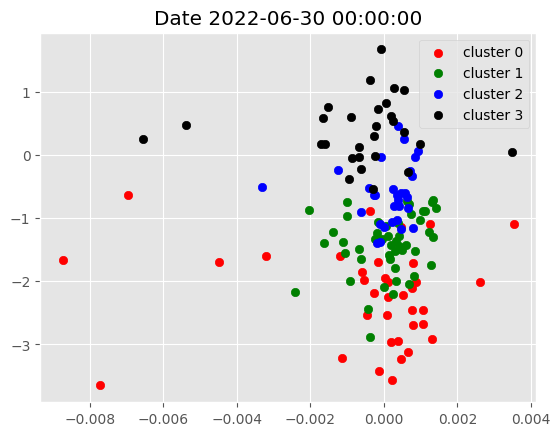

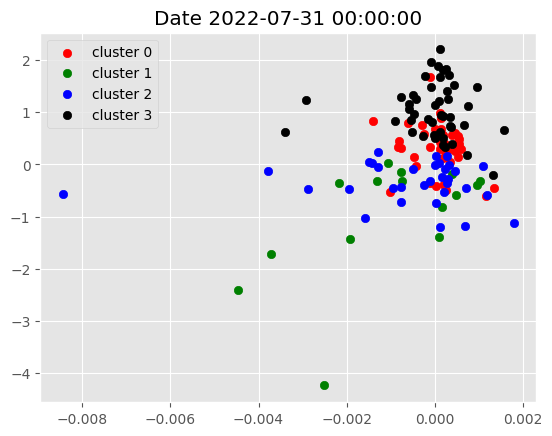

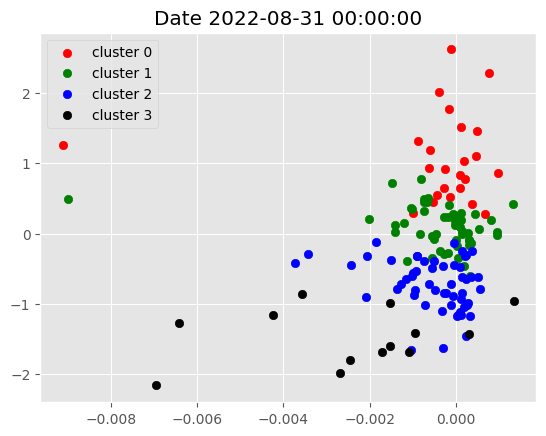

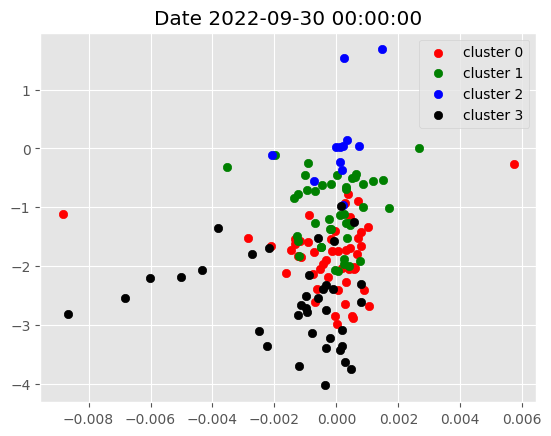

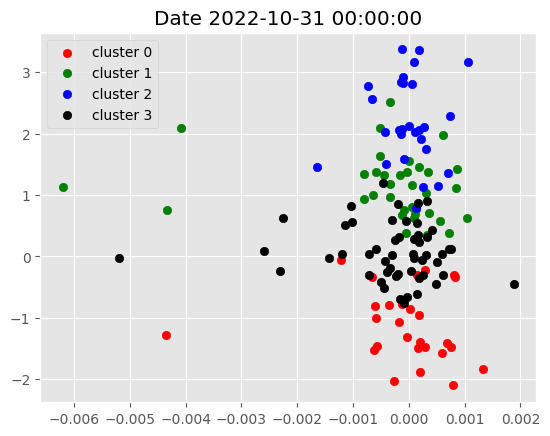

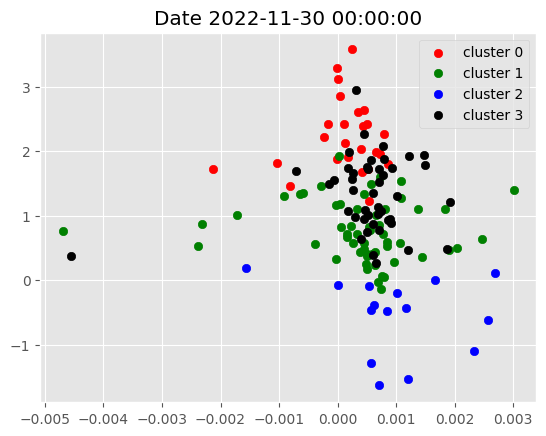

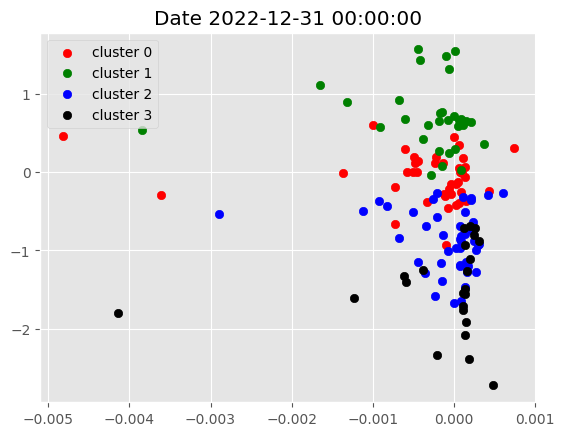

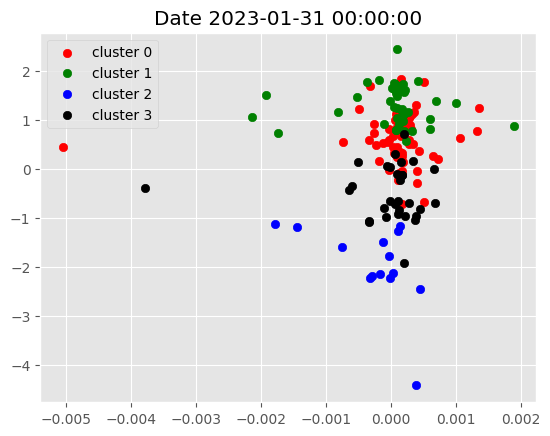

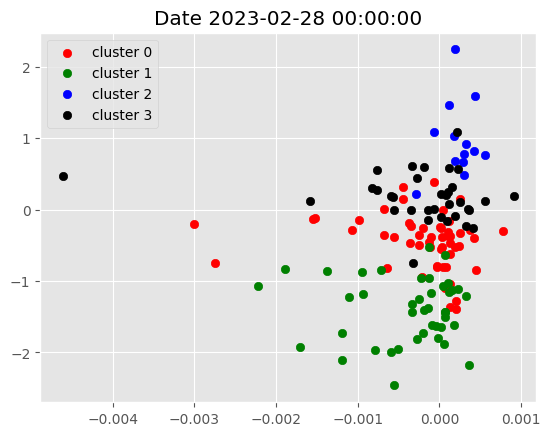

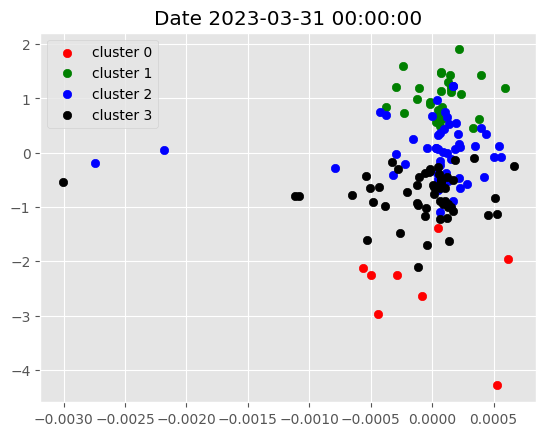

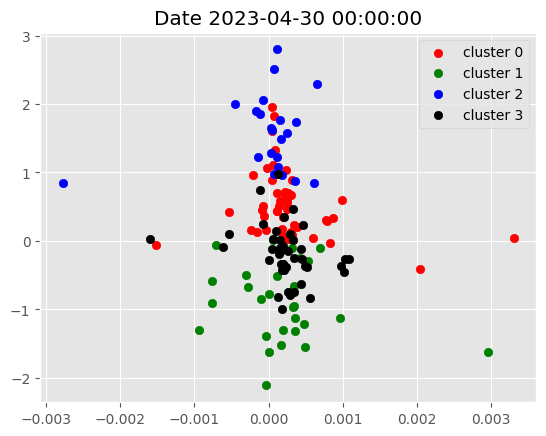

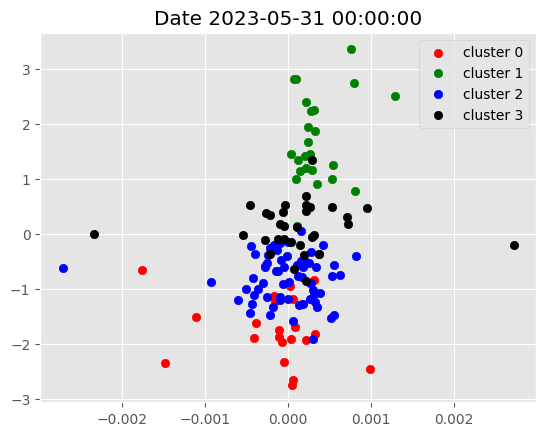

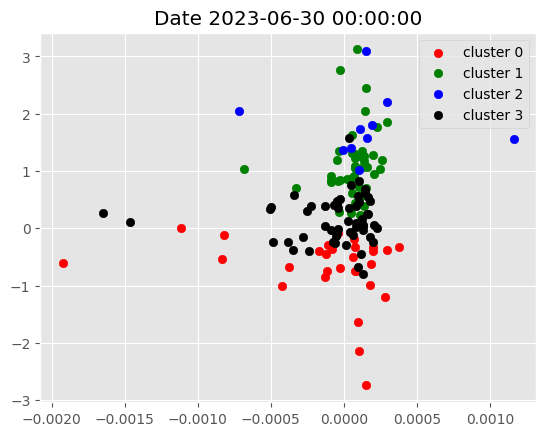

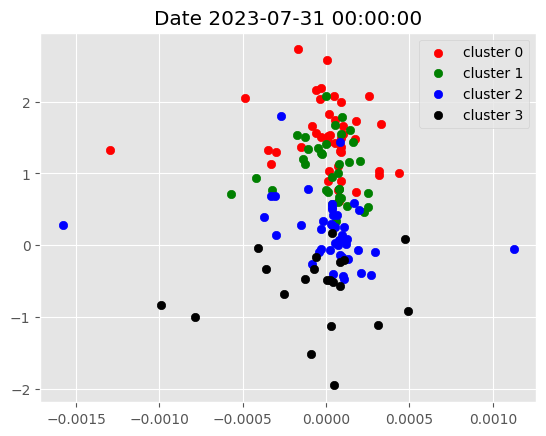

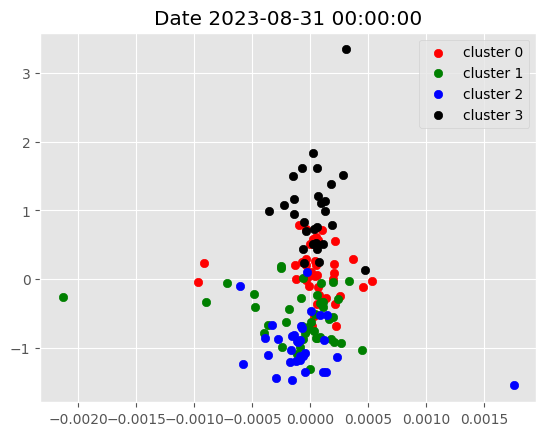

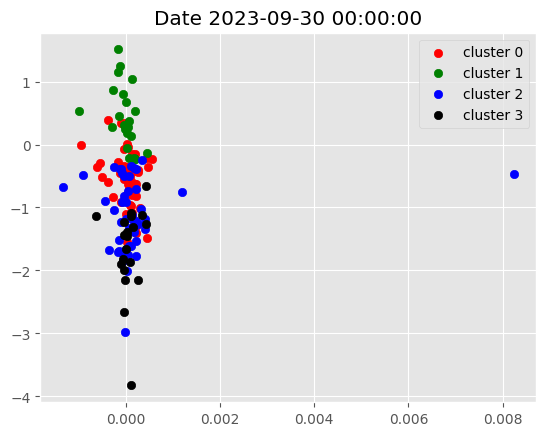

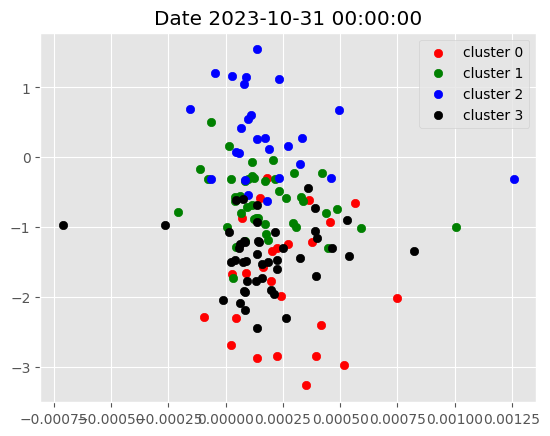

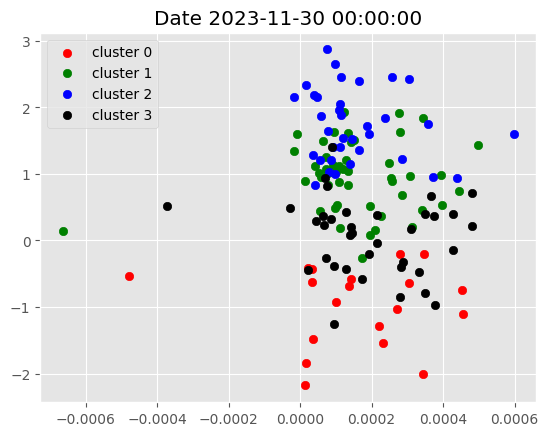

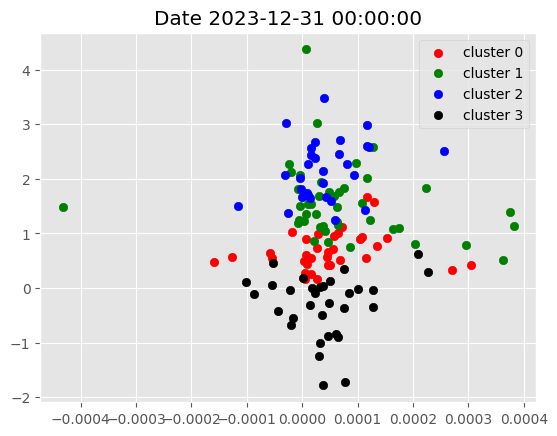

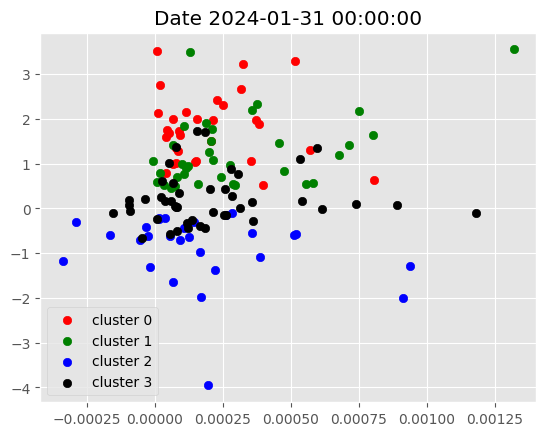

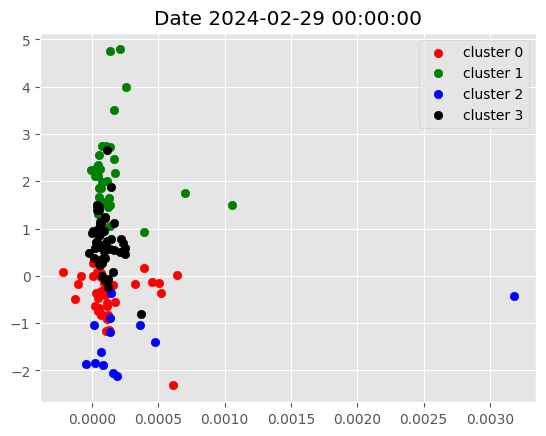

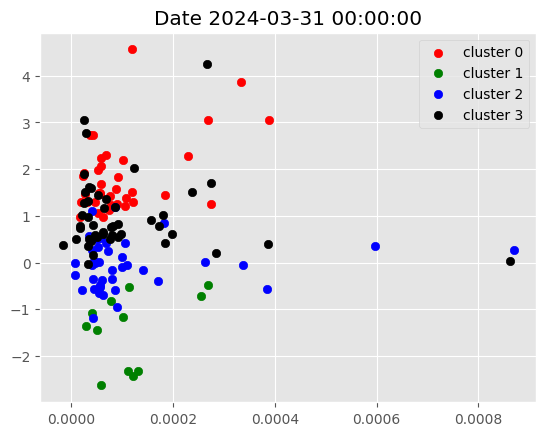

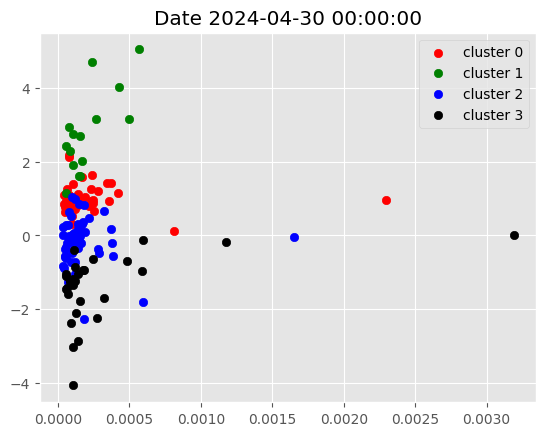

In [43]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## Apply pre-defined centroids.

In [45]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

### Step 7: Asset Selection and Portfolio Optimization

- First, we will filter only stocks corresponding to the cluster we choose based on our hypothesis.
- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.



In [68]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-05-01': ['AAL',
  'BMY',
  'CHTR',
  'CL',
  'CMCSA',
  'DE',
  'EBAY',
  'FCX',
  'GS',
  'LMT',
  'LUV',
  'MDLZ',
  'MMM',
  'MO',
  'NOC',
  'NXPI',
  'PEP',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'T',
  'WDC'],
 '2018-06-01': ['AAL',
  'ABBV',
  'AMAT',
  'AMT',
  'AXP',
  'AZO',
  'BKNG',
  'CAT',
  'CVS',
  'CVX',
  'DAL',
  'DD',
  'DE',
  'DHR',
  'EOG',
  'FCX',
  'FDX',
  'GE',
  'HON',
  'KO',
  'KR',
  'LRCX',
  'MAR',
  'MCD',
  'MET',
  'NOC',
  'ORCL',
  'PEP',
  'PXD',
  'REGN',
  'RTX',
  'SBUX',
  'SCHW',
  'SHW',
  'SLB',
  'STZ',
  'TMO',
  'TSLA',
  'UAL',
  'USB',
  'VZ',
  'WDC',
  'WFC'],
 '2018-07-01': ['ACN',
  'AMGN',
  'AMT',
  'AMZN',
  'BMY',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KO',
  'KR',
  'LLY',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX',
  'TSLA',
  'VZ',
  'XOM'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BMY',
  'C',
  'CL',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',

## Define Portfolio Optimization Function

- We will define a function which optimizes portfolio weights using `PyPortfolioOpt` package and `EfficientFrontier` optimizer to maximize the Sharpe ratio.
- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.
- Apply single stock weight bounds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio).


In [69]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

- Download Fresh Daily Prices Data only for short listed stocks.

In [70]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  157 of 157 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-05-01  40.753750   34.207825   49.388081   38.669170  109.154327   
2017-05-02  42.487328   34.424850   49.499516   38.775890  108.641205   
2017-05-03  42.535751   34.319839   49.581238   38.882618  108.299118   
2017-05-04  42.526066   34.196156   49.945259   39.656364  108.767220   
2017-05-05  43.107159   34.763252   49.766953   39.700817  109.397400   
...               ...         ...         ...         ...         ...   
2024-04-05  13.760000  169.580002  170.000000  111.199997  331.715607   
2024-04-08  13.900000  168.449997  169.800003  110.519997  330.520203   
2024-04-09  13.950000  169.669998  170.139999  112.440002  333.160004   
2024-04-10  13.410000  167.779999  169.029999  111.169998  324.399994   
2024-04-11  13.620000  175.039993  167.520004  111.449997  325.190002   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-05-01  135.110001   89.700409   91.980003  51.175209   38.453995  ...   
2017-05-02  135.000000   89.734924   93.449997  51.108746   38.463215  ...   
2017-05-03  134.850006   84.127060   93.349998  51.117058   38.315674  ...   
2017-05-04  134.610001   85.498802   93.250000  52.055664   38.380222  ...   
2017-05-05  134.839996   85.662735   93.239998  52.088894   38.573868  ...   
...                ...         ...         ...        ...         ...  ...   
2024-04-05  485.119995  244.850006  244.740005  77.709999  207.850006  ...   
2024-04-08  484.279999  246.639999  245.889999  77.849998  209.039993  ...   
2024-04-09  492.549988  250.009995  247.929993  75.519997  210.410004  ...   
2024-04-10  487.220001  245.789993  239.009995  75.320000  209.250000  ...   
2024-04-11  484.279999  244.419998  241.059998  74.169998  212.979996  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-05-01   9042100  5432900  2108800  14455200   3380000  8368400  13915800   
2017-05-02  11627700  4476300  2465400  13397800   4013900  4849300  15634900   
2017-05-03   4909000  2993300  1333300  19568100   3288400  4382100  15737100   
2017-05-04   5257000  3068300  1672700  20767700   3561500  3337800  17054100   
2017-05-05   8844500  4668900  2545100  17133000   4187100  3057000  13078800   
...              ...      ...      ...       ...       ...      ...       ...   
2024-04-05   4388100  2416200   695700  14330100   9994700  8260900  11079400   
2024-04-08   5542400  2539200   751900  14457800  11578400  7550400  15308800   
2024-04-09   7314300  3502600   727100  17227000  11107000  8326500  10646000   
2024-04-10   5276000  3472200  1026700  17900400  24397400  7681300  16475200   
2024-04-11   8101400  2414000  1060200  14762900  13663100  5928200  18982000   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-05-01  18497700  2138700   8664100  
2017-05-02  21955200  1497500   9102900  
2017-05-03  16570800  1322800  10289000  
2017-05-04  16502400  1423300  16164500  
2017-05-05  16793400  3086100  10213000  
...              ...      ...       ...  
2024-04-05  10332300  1437600  21714100  
2024-04-08  11070100  1170100  17513900  
2024-04-09  10015900   930300  14135700  
2024-04-10  15097600  1449800  17409200  
2024-04-11  10984700   847500  17553600  

[1749 rows x 942 columns]

- Calculate daily returns for each stock which could land up in our portfolio.

- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

- If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

- Calculated each day portfolio return.

In [75]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

##### follow line by lione for error ###
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    # try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]
        print(cols)

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    # except Exception as e:
    #     print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df


['AAL', 'BMY', 'CHTR', 'CL', 'CMCSA', 'DE', 'EBAY', 'FCX', 'GS', 'LMT', 'LUV', 'MDLZ', 'MMM', 'MO', 'NOC', 'NXPI', 'PEP', 'PG', 'PM', 'QCOM', 'REGN', 'RTX', 'SHW', 'T', 'WDC']
['AAL', 'ABBV', 'AMAT', 'AMT', 'AXP', 'AZO', 'BKNG', 'CAT', 'CVS', 'CVX', 'DAL', 'DD', 'DE', 'DHR', 'EOG', 'FCX', 'FDX', 'GE', 'HON', 'KO', 'KR', 'LRCX', 'MAR', 'MCD', 'MET', 'NOC', 'ORCL', 'PEP', 'PXD', 'REGN', 'RTX', 'SBUX', 'SCHW', 'SHW', 'SLB', 'STZ', 'TMO', 'TSLA', 'UAL', 'USB', 'VZ', 'WDC', 'WFC']
['ACN', 'AMGN', 'AMT', 'AMZN', 'BMY', 'BSX', 'COST', 'CRM', 'EA', 'EOG', 'KO', 'KR', 'LLY', 'MDLZ', 'NEE', 'NFLX', 'NKE', 'PEP', 'PG', 'REGN', 'SHW', 'TJX', 'TSLA', 'VZ', 'XOM']
['ABT', 'AMD', 'AMGN', 'AMT', 'BMY', 'C', 'CL', 'CMCSA', 'COST', 'CSX', 'DIS', 'ELV', 'EOG', 'EXPE', 'GILD', 'HON', 'JNJ', 'JPM', 'KO', 'KR', 'LLY', 'LMT', 'LUV', 'MDLZ', 'MDT', 'MMM', 'MRK', 'ORLY', 'PEP', 'PFE', 'PG', 'PM', 'QCOM', 'REGN', 'RTX', 'SHW', 'TGT', 'TJX', 'TMO', 'UAL', 'UNP', 'UPS', 'USB', 'VLO', 'WMT']
['AAPL', 'ADP', 'AMD',

In [54]:
portfolio_df


""


In [52]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,SPY Buy&Hold
